## Importación de las librerías

In [2]:
from scipy import stats
from sklearn import preprocessing

import statsmodels.api as sm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## Importación del dataset

Variables:
- id: identificador único
- gender: "Masculino", "Femenino" u "Otro".
- age: edad del paciente
- hypertension: 0 si el paciente no tiene hipertensión, 1 si el paciente tiene hipertensión
- heart_disease: 0 si el paciente no tiene ninguna cardiopatía, 1 si el paciente tiene una cardiopatía
- ever_married: "No" o "Sí"
- work_type: "niños", "Govt_jov", "Nunca_trabajó", "Privado" o "Autónomo"
- residence_type: "Rural" o "Urbana"
- avg_glucose_level: nivel medio de glucosa en sangre
- bmi: índice de masa corporal
- smoking_status: "antes fumaba", "nunca ha fumado", "fuma" o "desconocido". "Desconocido" significa que la información no está disponible para este paciente
- stroke: 1 si el paciente sufrió un ictus o 0 en caso contrario

In [3]:
stroke_df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Número de filas y variables

In [4]:
stroke_df.shape

(5110, 12)

## Análisis exploratorio de los datos

### Descripción inicial

Descripción inicial de las columnas del dataframe.

- La variable id se puede borrar, ya que no aportará nada relevante en la predicción 
- En la variable bmi existen valores perdidos
- hypertension es una variable categorica binaria (0 o 1)
- heart_disease es una variable categorica binaria (0 o 1)

In [5]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Borramos la variable id

In [6]:
del stroke_df['id']

### Ditribución de la variable objetivo

Se observa la distribución inicial de la clase objetivo. Se trata de un dataset bastante desbalanceado.

[Text(0, 0, '4861'), Text(0, 0, '249')]

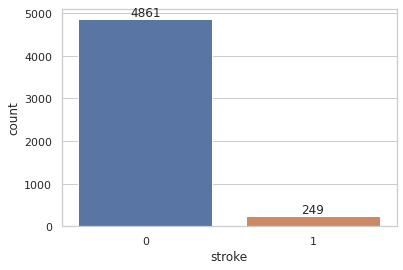

In [7]:
ax = sns.countplot(x='stroke', data=stroke_df)
ax.bar_label(ax.containers[0])

### Variables continuas solas

Realizando una descripción inicial de las variables cuantitativas:
- age: su valor mínimo es 0.08 (en años), lo que significa que existen observaciones que presentan edades en meses
- avg_glucose_level: parece mostrar un valor máximo muy alto y también un mínimo bastante bajo (estudiarlo)
- bmi: posibilidad de la existencia de outliers, valores máximos y mínimos extremos. Además, de que presenta valores perdidos.

In [8]:
stroke_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Distribución de la variable **age**:
- No sigue una forma (parecida) a una normal, se confirma con el histograma y el qqplot de manera muy clara

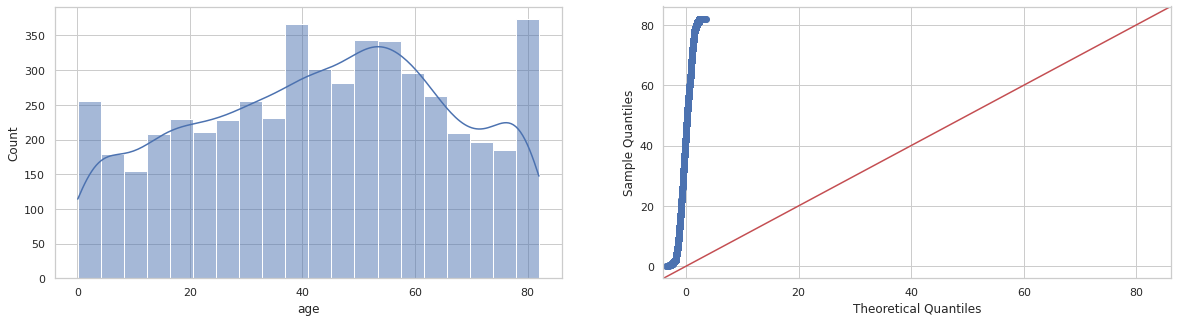

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

sns.histplot(data=stroke_df, x="age", kde=True, ax=axes[0])

#create Q-Q plot with 45-degree line added to plot
_ = sm.qqplot(stroke_df.age, line='45', ax=axes[1])

Al no seguir la variable una distribución normal usamos el IQR para la detección de outliers con +- 3.

En el boxplot no se detectan outliers en la variable age. Y tampoco con el criterio de IQR según el +- 3 (https://www.cloudyml.com/blog/outlier-detection-and-treatment/)


In [10]:
def detect_outliers_iqr(data, factor=3):
    # finding the 1st quartile
    q1 = np.nanquantile(data, 0.25)
 
    # finding the 3rd quartile
    q3 = np.nanquantile(data, 0.75)
 
    # finding the iqr region
    iqr = q3-q1
        
    # finding upper and lower whiskers
    upper_bound = q3+(factor*iqr)
    lower_bound = q1-(factor*iqr)
                    
    return len(data[(data<lower_bound) | (data>upper_bound)])


Posible Outliers IQR: 0


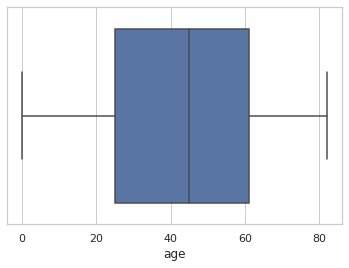

In [11]:
sns.boxplot(x=stroke_df["age"])
print("\nPosible Outliers IQR:", detect_outliers_iqr(stroke_df.age))

Distribución de la variable **avg_glucose_level**:
- No sigue una forma (parecida) a una normal, se confirma con el histograma y el qqplot de manera muy clara
- Además, se puede observar que la distribución es sesgada hacia la izquierda.

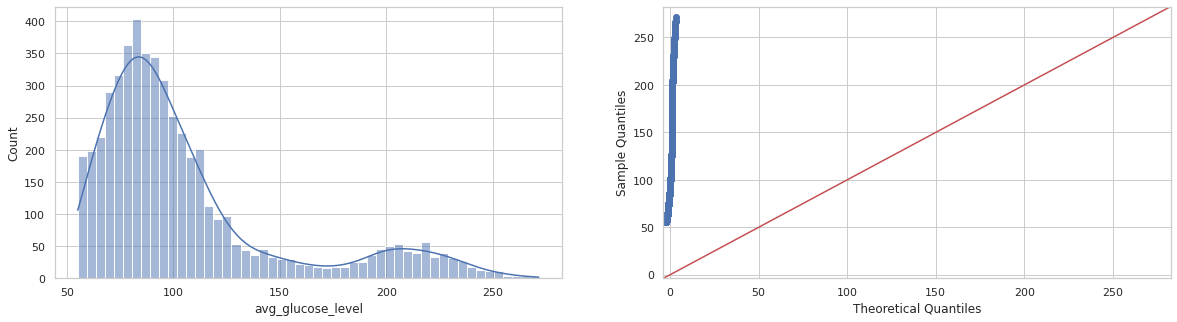

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

sns.histplot(data=stroke_df, x="avg_glucose_level", kde=True, ax=axes[0])

#create Q-Q plot with 45-degree line added to plot
_ = sm.qqplot(stroke_df.avg_glucose_level, line='45', ax=axes[1])

Al no seguir la variable una distribución normal usamos el IQR para la detección de outliers con +- 3.

En el boxplot (basado en 1.5) se observan un número alto de observaciones (casi el 12%) que se encuentra por arriba de upper_bound. Pero al usar el criterio con +- 3 se detectan solo 166 observaciones como outliers los cuales frente a las 5110 representan el 3.2% (nada significativo). 

**Cosas a probar**: cambiar escala de la variable (transformaciones boxcox) ¿reduce la cantidad de outliers?


Posible Outliers IQR: 166 -> 3.24853228962818 %


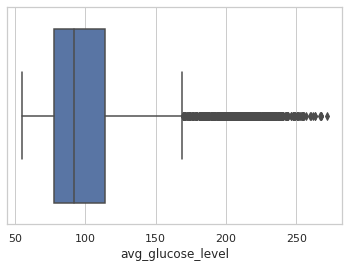

In [13]:
sns.boxplot(x=stroke_df["avg_glucose_level"])
posible_outliers = detect_outliers_iqr(stroke_df.avg_glucose_level)
print("\nPosible Outliers IQR:", posible_outliers, "->", posible_outliers/len(stroke_df.avg_glucose_level)*100 ,"%")

Distribución de la variable **bmi**: no sigue la forma de una normal, aunque no está tan sesgada hacia un lado como la anterior

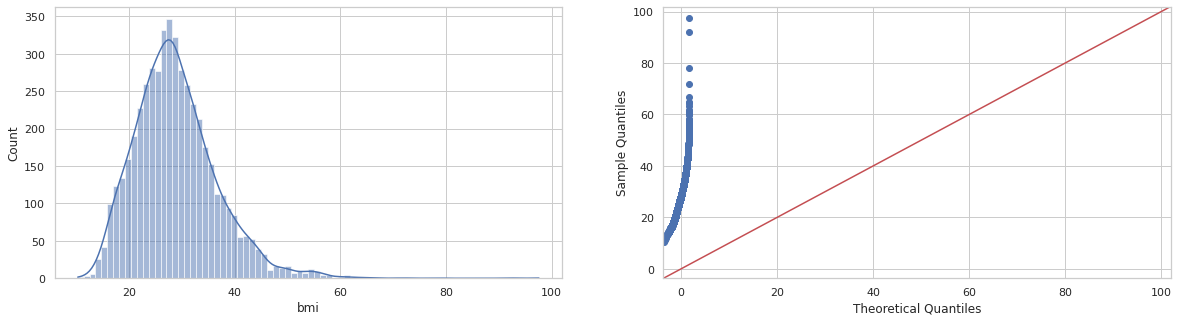

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))

sns.histplot(data=stroke_df, x="bmi", kde=True, ax=axes[0])

#create Q-Q plot with 45-degree line added to plot
_ = sm.qqplot(stroke_df.bmi, line='45', ax=axes[1])

# stats.shapiro(stroke_df[~stroke_df['bmi'].isna()].bmi)

Se observan que existen observaciones que se encuentra por arriba de upper_bound, aunque son solo 8/4909 (tiene datos faltantes) que supone cerca del 0.1% no son nada significantes, según el criterio de +- 3 IQR.

**Cosas a probar**:
- cambiar escala de la variable (transformaciones box cox) ¿reduce la cantidad de outliers?


Posible Outliers IQR: 8 -> 0.16296598085149724 %


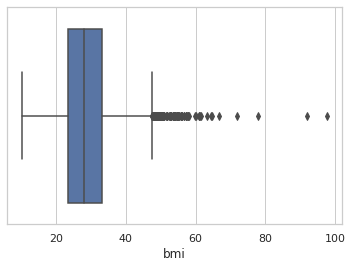

In [15]:
sns.boxplot(x=stroke_df["bmi"])
posible_outliers = detect_outliers_iqr(stroke_df.bmi)
print("\nPosible Outliers IQR:", posible_outliers, "->", posible_outliers/len(stroke_df[~stroke_df['bmi'].isna()].bmi)*100 ,"%")

### Variables continuas cruzadas con otras continuas

- Se puede observar que en un principio no se detecta relación lineal o no lineal alguna entre las variables CONTINUAS. Esto se puede confirmar mirando los diferentes scatterplots de abajo.

<AxesSubplot:xlabel='avg_glucose_level', ylabel='bmi'>

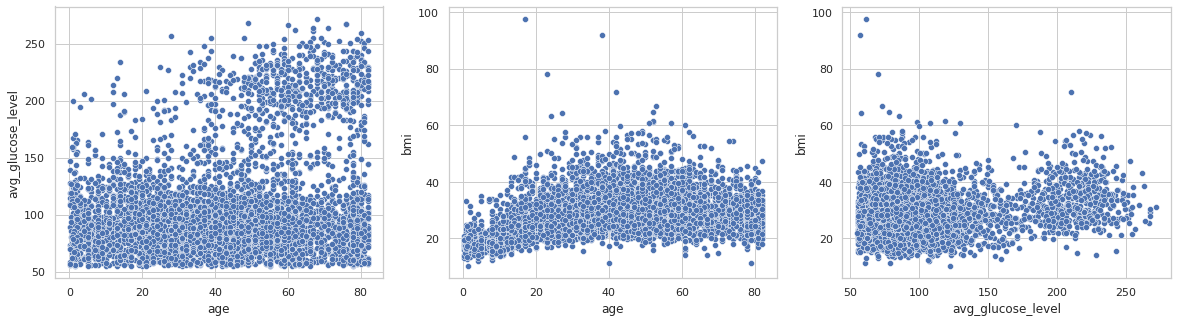

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.scatterplot(data=stroke_df, x="age", y="avg_glucose_level", ax=axes[0])
sns.scatterplot(data=stroke_df, x="age", y="bmi", ax=axes[1])
sns.scatterplot(data=stroke_df, x="avg_glucose_level", y="bmi", ax=axes[2])

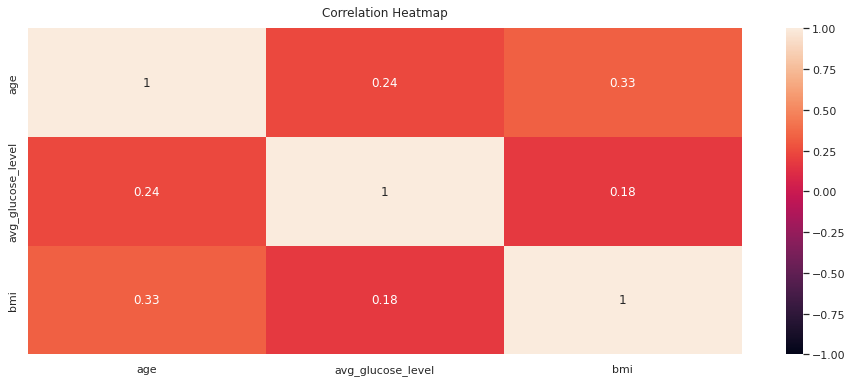

In [21]:
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(stroke_df[['age', 'avg_glucose_level', 'bmi']].corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Variables continuas cruzadas con la variable objetivo

Cruzadas de las variables continuas con la objetivo:
- **age**: se puede observar que las personas que tienen un valor 1 en stroke suelen tener una mayor edad. (**SIRVE PARA DISCRIMINAR A LA VARIABLE OBJETIVO**)
- **avg_glucose_level**: se puede observar que las personas que tienen un valor 1 en stroke suelen tener un mayor nivel medio de glucosa (no parece haber una diferencia significativa). (**TAL VEZ PUEDA SERVIR PARA DISCRIMINAR A LA VARIABLE OBJETIVO**)
- **bmi**: las personas con stroke tienen mayor media, pero no parece ser significativa. (**NO PERMITE DISCRIMINAR A LA VARIABLE OBJETIVO A PRIMERA VISTA**)

<AxesSubplot:xlabel='bmi'>

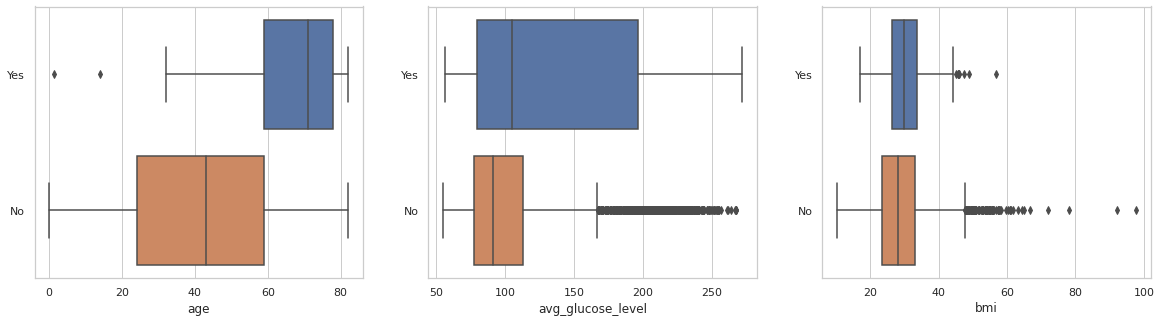

In [22]:
stroke_categorical = ["Yes"  if obs == 1 else "No" for obs in list(stroke_df.stroke)]

fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.boxplot(data=stroke_df, x="age", y=stroke_categorical, ax=axes[0])
sns.boxplot(data=stroke_df, x="avg_glucose_level", y=stroke_categorical, ax=axes[1])
sns.boxplot(data=stroke_df, x="bmi", y=stroke_categorical, ax=axes[2])

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

Aplicamos el test de **Kruskal-Wallis H-test** para las siguientes hipotesis:
- H0: la mediana de la población de todos los grupos es igual
- H1: H0 no es cierta

En las tres variables continuas parece ser que la mediana de la población no es igual en ambos grupos (0 vs 1)

In [23]:
# AGE: se rechaza la H0
print(stats.kruskal(list(stroke_df.loc[stroke_df.stroke == 1].age), list(stroke_df.loc[stroke_df.stroke == 0].age)))

# AVG_GLUCOSE_LEVEL: se rechaza la H0
print(stats.kruskal(list(stroke_df.loc[stroke_df.stroke == 1].avg_glucose_level), list(stroke_df.loc[stroke_df.stroke == 0].avg_glucose_level)))

# BMI: se rechaza la H0
print(stats.kruskal(list(stroke_df.loc[stroke_df.stroke == 1].bmi), list(stroke_df.loc[stroke_df.stroke == 0].bmi), nan_policy='omit'))

KruskalResult(statistic=318.1166209843264, pvalue=3.725166547874254e-71)
KruskalResult(statistic=34.80739568673386, pvalue=3.639881441958809e-09)
KruskalResult(statistic=15.087653240803583, pvalue=0.00010263237377217099)


### Tratamiento de outliers en las variables continuas

Función que aplica la mejor transformación box-cox y devuelve la variable tranaformada y el lambda utilizado

In [46]:
def box_cox_transformation(var):
    power_transformer = preprocessing.PowerTransformer(method='box-cox')
    var_transformed = power_transformer.fit_transform(var)
    return (var_transformed, power_transformer.lambdas_)

Las variables **bmi** y **avg_glucose_level** presentan outliers.

- Se aplica la función box_cox para obtener la mejor transformación sobre dichas y se presentan nuevamente el número de outliers.
- Se puede observar que en la variable bmi y avg_glucose_level los outliers desaparecen con la transformación box-cox aplicada.

In [52]:
bmi_transformed, lambda_bmi = box_cox_transformation(stroke_df[['bmi']])
avg_glucose_level_transformed, lambda_avg_glucose_level = box_cox_transformation(stroke_df[['avg_glucose_level']])


Posible Outliers IQR: 1 -> 0.020370747606437156 %


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


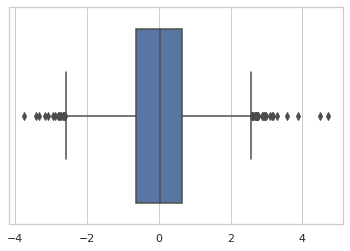

In [56]:
sns.boxplot(bmi_transformed)
posible_outliers = detect_outliers_iqr(bmi_transformed)
print("\nPosible Outliers IQR:", posible_outliers, "->", posible_outliers/len(stroke_df[~stroke_df['bmi'].isna()].bmi)*100 ,"%")


Posible Outliers IQR: 0 -> 0.0 %


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


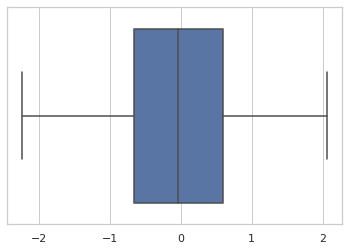

In [57]:
sns.boxplot(avg_glucose_level_transformed)
posible_outliers = detect_outliers_iqr(avg_glucose_level_transformed)
print("\nPosible Outliers IQR:", posible_outliers, "->", posible_outliers/len(stroke_df.avg_glucose_level)*100 ,"%")

Asímismo, se observa que las transformaciones box-cox aplicadas logran centrar la distribución de datos, que anteriormente estaban sesgadas hacia la izquierda.

[Text(0.5, 0, 'bmi_transformed')]

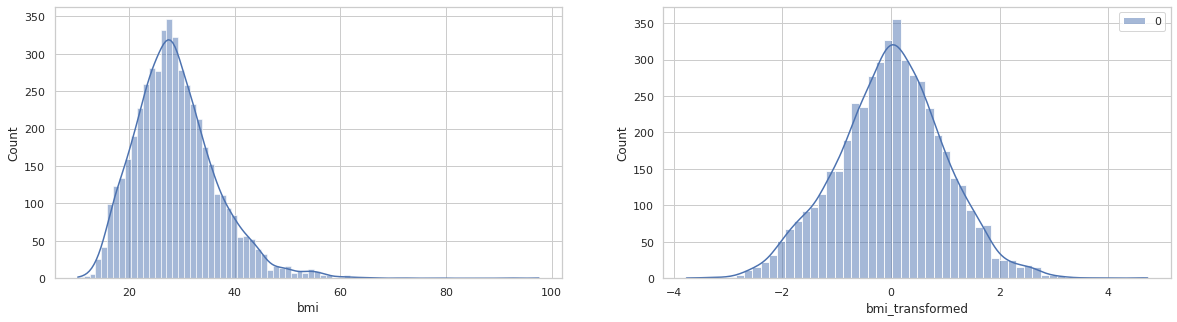

In [63]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
sns.histplot(data=stroke_df, x='bmi', kde=True, ax=axes[0])
sns.histplot(bmi_transformed, kde=True, ax=axes[1]).set(xlabel='bmi_transformed')

[Text(0.5, 0, 'avg_glucose_level_transformed')]

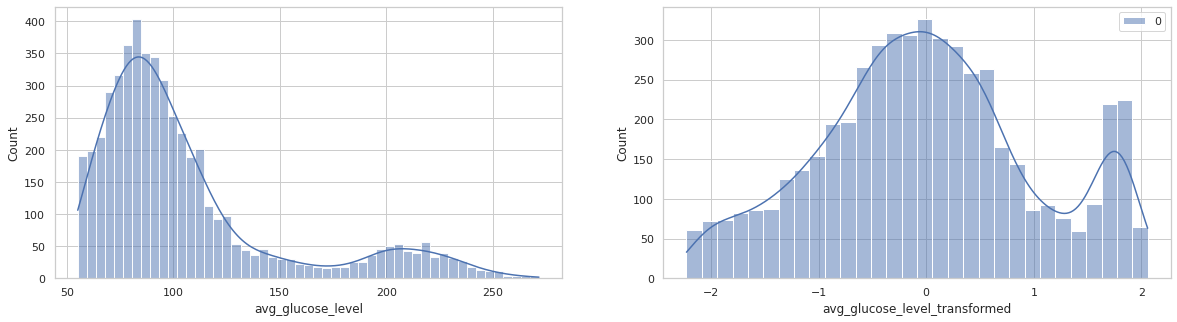

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
sns.histplot(data=stroke_df, x='avg_glucose_level', kde=True, ax=axes[0])
sns.histplot(avg_glucose_level_transformed, kde=True, ax=axes[1]).set(xlabel='avg_glucose_level_transformed')

### Variables categoricas solas

Se observan las categorías:
- **gender**: la categoría other solo tiene una observación, por lo tanto se borrará. Con respecto a las otras dos categorías parecen tener un número significativo de observaciones.
- **hypertension**: la categoría 1 tiene muy pocas muestras ¿estará relacionada con la variable objetivo?
- **heart_disease**: igual que la de arriba, ¿estará relacionada con la variable objetivo?
- **ever_married**: ambas categorías disponen de muestras.
- **work_type**: la última categoría no tiene muchas muestras.
- **Residence_type**: tiene aproximadamente el mismo número de muestras en ambas categorías.
- **smoking_status**: categorías representadas.

In [65]:
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

In [66]:
for var in categorical_vars:
    print("VARIABLE", var)
    print(stroke_df[var].value_counts())
    print("-"*100)

VARIABLE gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE hypertension
0    4612
1     498
Name: hypertension, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE heart_disease
0    4834
1     276
Name: heart_disease, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
----------------------------------------------------------------------------------------------------
VARIABLE Residenc

Borramos la muestra que tiene como género other.

In [67]:
stroke_df = stroke_df[stroke_df.gender != 'Other'].reset_index(drop=True)
stroke_df.shape

(5109, 11)

En la categoría de **Never_worked** no existe ninguna observación que haya sufrido stroke=1. Además, si nos fijamos en la edad máxima es 23 (para una observación) y se puede observar que estas muestras podrían encajar perfectamente en la categoría de **children**. Es por ello, que se juntan las categorías de **children** y **Never_worked** como **children**, aunque también se podría poner una nueva categoría nueva como **not_work_age**.

In [68]:
print("Max age children:", stroke_df[(stroke_df.work_type == 'children')].age.max())
print("Min age children:", stroke_df[(stroke_df.work_type == 'children')].age.min())
print('-'*30)
print("Max age Never_worked:", stroke_df[(stroke_df.work_type == 'Never_worked')].age.max())
print("Min age Never_worked:", stroke_df[(stroke_df.work_type == 'Never_worked')].age.min())
print('-'*30)
stroke_df[(stroke_df.work_type == 'Never_worked')].sort_values(['age'])

Max age children: 16.0
Min age children: 0.08
------------------------------
Max age Never_worked: 23.0
Min age Never_worked: 13.0
------------------------------


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4409,Male,13.0,0,0,No,Never_worked,Urban,85.08,14.6,Unknown,0
939,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
1789,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
253,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
3195,Male,14.0,0,0,No,Never_worked,Urban,137.91,41.8,never smoked,0
2346,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
3971,Male,15.0,0,0,No,Never_worked,Urban,64.29,16.7,Unknown,0
2740,Male,15.0,0,0,No,Never_worked,Rural,79.59,28.4,Unknown,0
2781,Female,16.0,0,0,No,Never_worked,Urban,84.40,25.9,never smoked,0
4067,Female,16.0,0,0,No,Never_worked,Urban,102.10,27.1,never smoked,0


In [69]:
stroke_df.work_type.replace('Never_worked', 'children', inplace=True)

Se representan las nuevas categorías

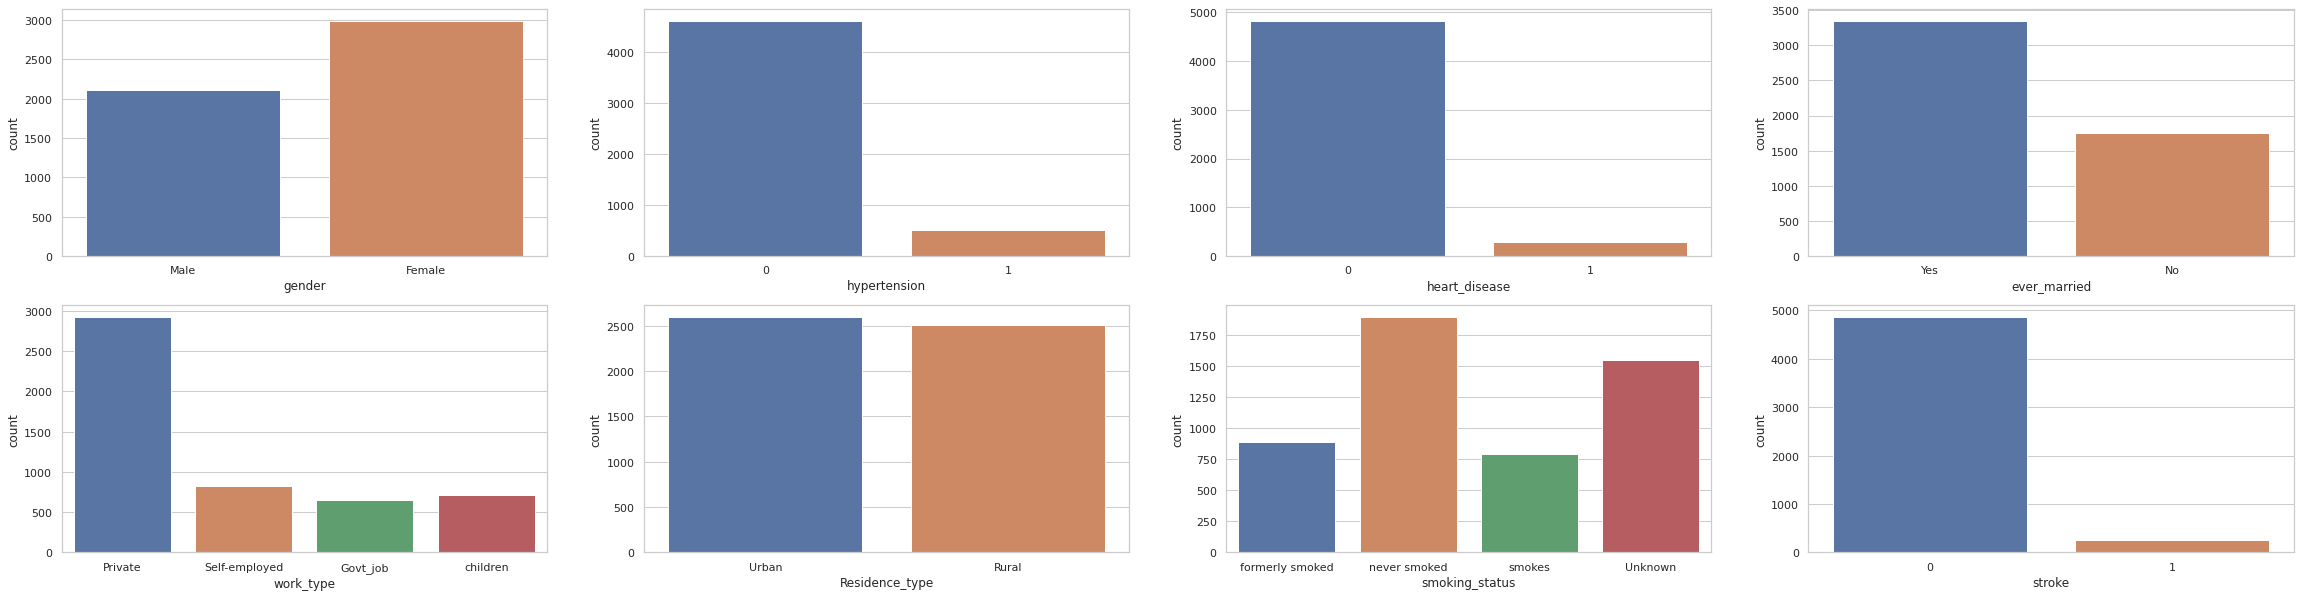

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 10))

for n, var in enumerate(categorical_vars):
    sns.countplot(data = stroke_df, x=var, ax=axes[n//4][n%4])

### Variables categóricas cruzadas contra otras categóricas

Calcularemos la matriz de V'Cramer entre las variables categóricas

In [71]:
label_encoder = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for var in categorical_vars:
    data_encoded[var] = label_encoder.fit_transform(stroke_df[var])

data_encoded.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
0,1,0,1,1,1,1,1,1
1,0,0,0,1,2,0,2,1
2,1,0,1,1,1,0,2,1
3,0,0,0,1,1,1,3,1
4,0,1,0,1,2,0,2,1


In [72]:
def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = stats.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

def get_cramers_df(data):
    rows = []
    for var1 in data:
        col = []
        for var2 in data:
            cramers = cramers_V(data[var1], data[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)
    cramers_results = np.array(rows)
    return pd.DataFrame(cramers_results, columns = data.columns, index= data.columns)

In [73]:
cramers_df = get_cramers_df(data_encoded)
cramers_df

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
gender,1.00,0.00,0.01,0.00,0.01,0.0,0.01,0.00
hypertension,0.00,1.00,0.01,0.03,0.03,0.0,0.02,0.02
heart_disease,0.01,0.01,1.00,0.01,0.01,0.0,0.01,0.02
ever_married,0.00,0.03,0.01,1.00,0.32,0.0,0.12,0.01
work_type,0.01,0.03,0.01,0.32,1.00,0.0,0.09,0.01
Residence_type,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00
smoking_status,0.01,0.02,0.01,0.12,0.09,0.0,1.00,0.01
stroke,0.00,0.02,0.02,0.01,0.01,0.0,0.01,1.00


Calculando la V de cramer entre las variables categóricas no se logra ver una relación ya sea lineal o no lineal entre las variables analizadas. Además, se puede observar que en principio no se ve ningún tipo de relación o muy débil entre las variables cualitativas y la objetivo. Confirmaremos posteriormente si estas variables permiten discriminar con respecto a la variable objetivo.

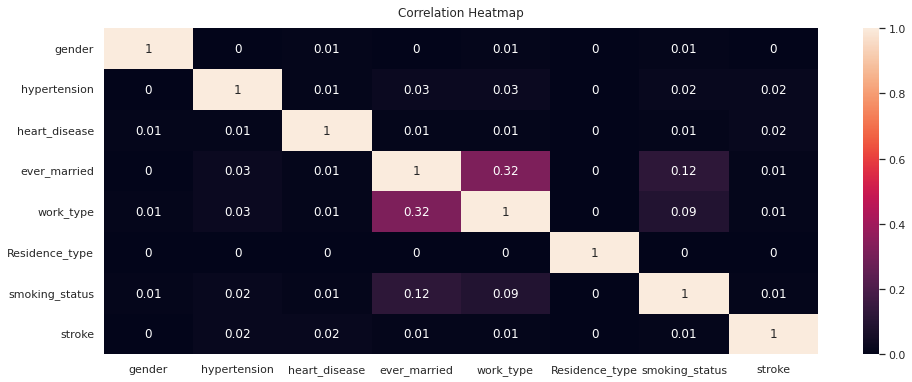

In [74]:
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(cramers_df, vmin=0, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Variables categóricas cruzadas con la variable objetibo binaria

Se puede observar que en las variables: **hypertension**, **heart_disease**, **ever_married** y **work_type** existen diferentes números de muestras con stroke=1 en cada una de las posibles categorías.


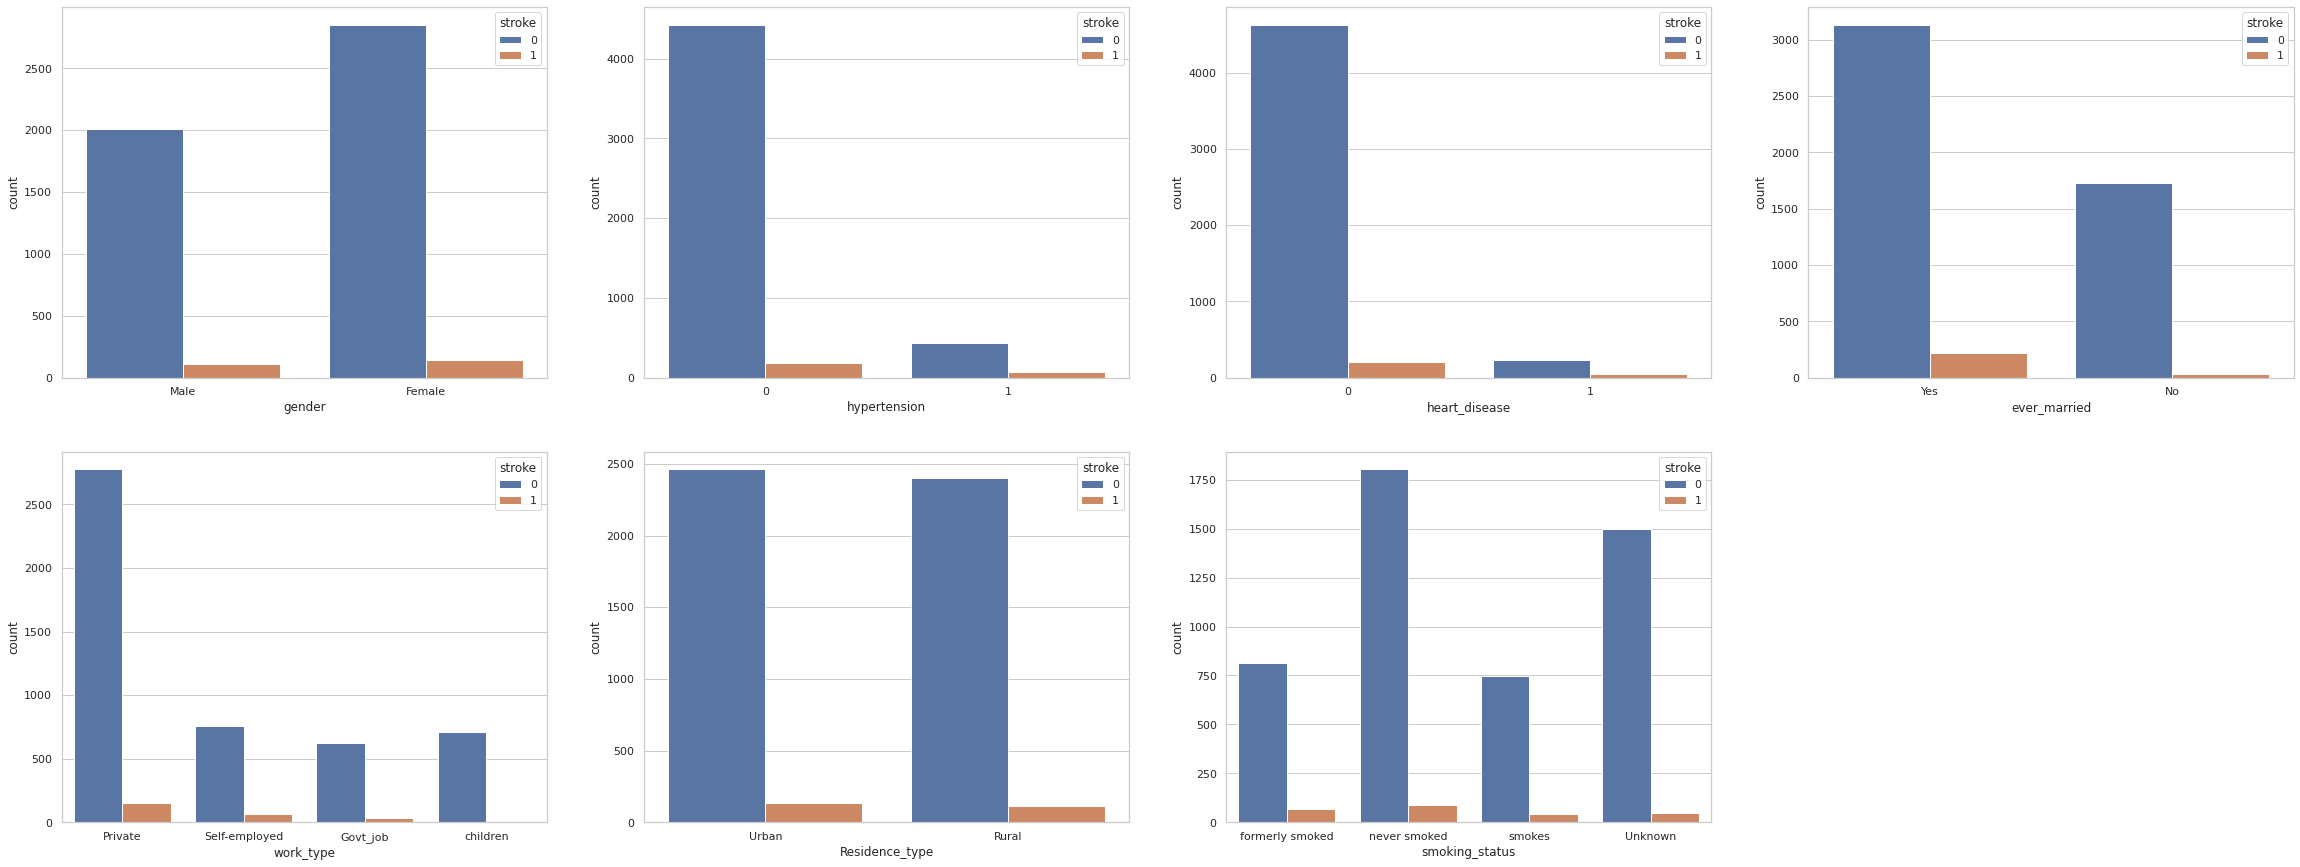

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,15))
fig.delaxes(axes[1,3])

for n, var in enumerate(categorical_vars[:len(categorical_vars)-1]):
    sns.countplot(data = stroke_df, x=var, hue=categorical_vars[-1], ax=axes[n//4][n%4])

### Variables continuas y categóricas cruzadas con la objetivo

- Podemos apreciar que la **edad** y **avg_glucose_level**, sea la categoría que sea de la variable analizada, es siempre mayor entre las personas que sufrieron stroke que las que no (¿lo mismo que antes?).
- Con respecto a la variable **bmi**, no parece haber una diferencia significativa con respecto a las categorías analizadas de las distintas variables (¿lo mismo que antes?)
- **Todo parece señalar que la variable BMI y aquellas categorías que no permiten discriminar con respecto a la variable objetivo, no van a ser buenas variables de predicción.**

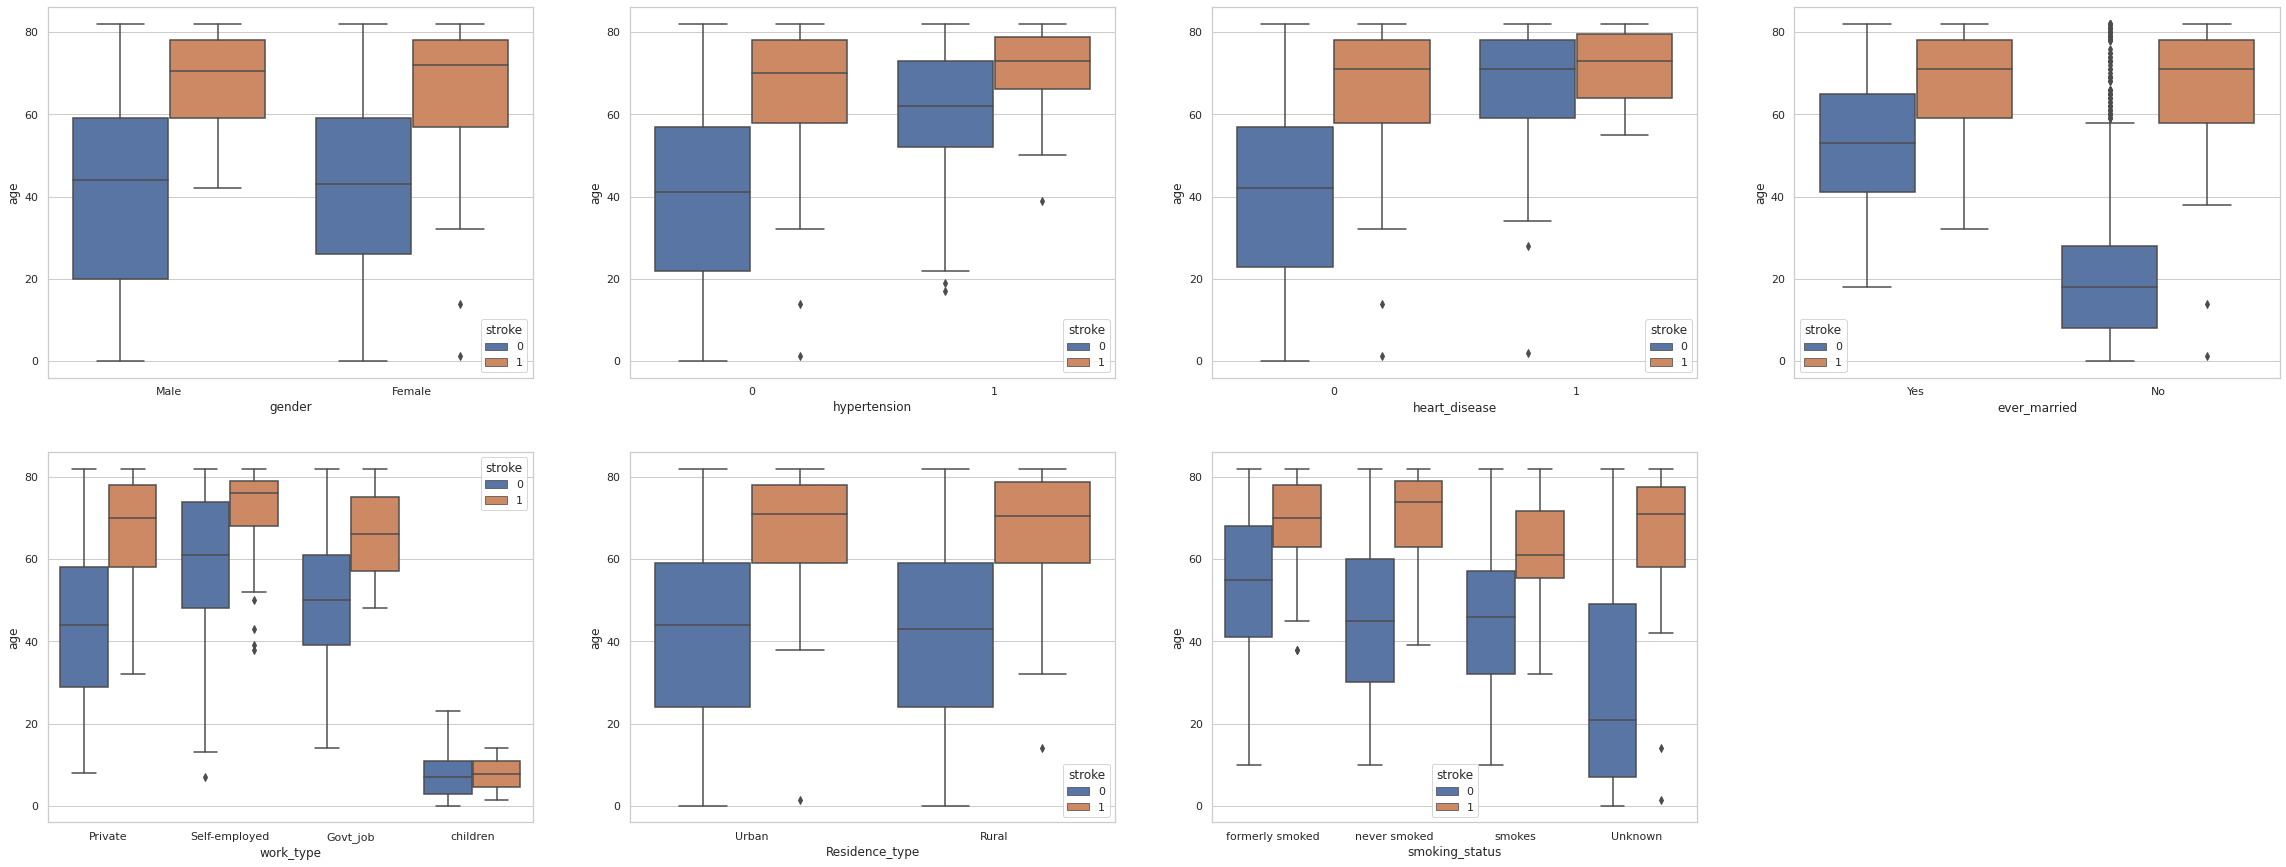

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,15))
fig.delaxes(axes[1,3])

for n, var in enumerate(categorical_vars[:len(categorical_vars)-1]):
    sns.boxplot(data = stroke_df, x=var, y='age', hue=categorical_vars[-1], ax=axes[n//4][n%4])

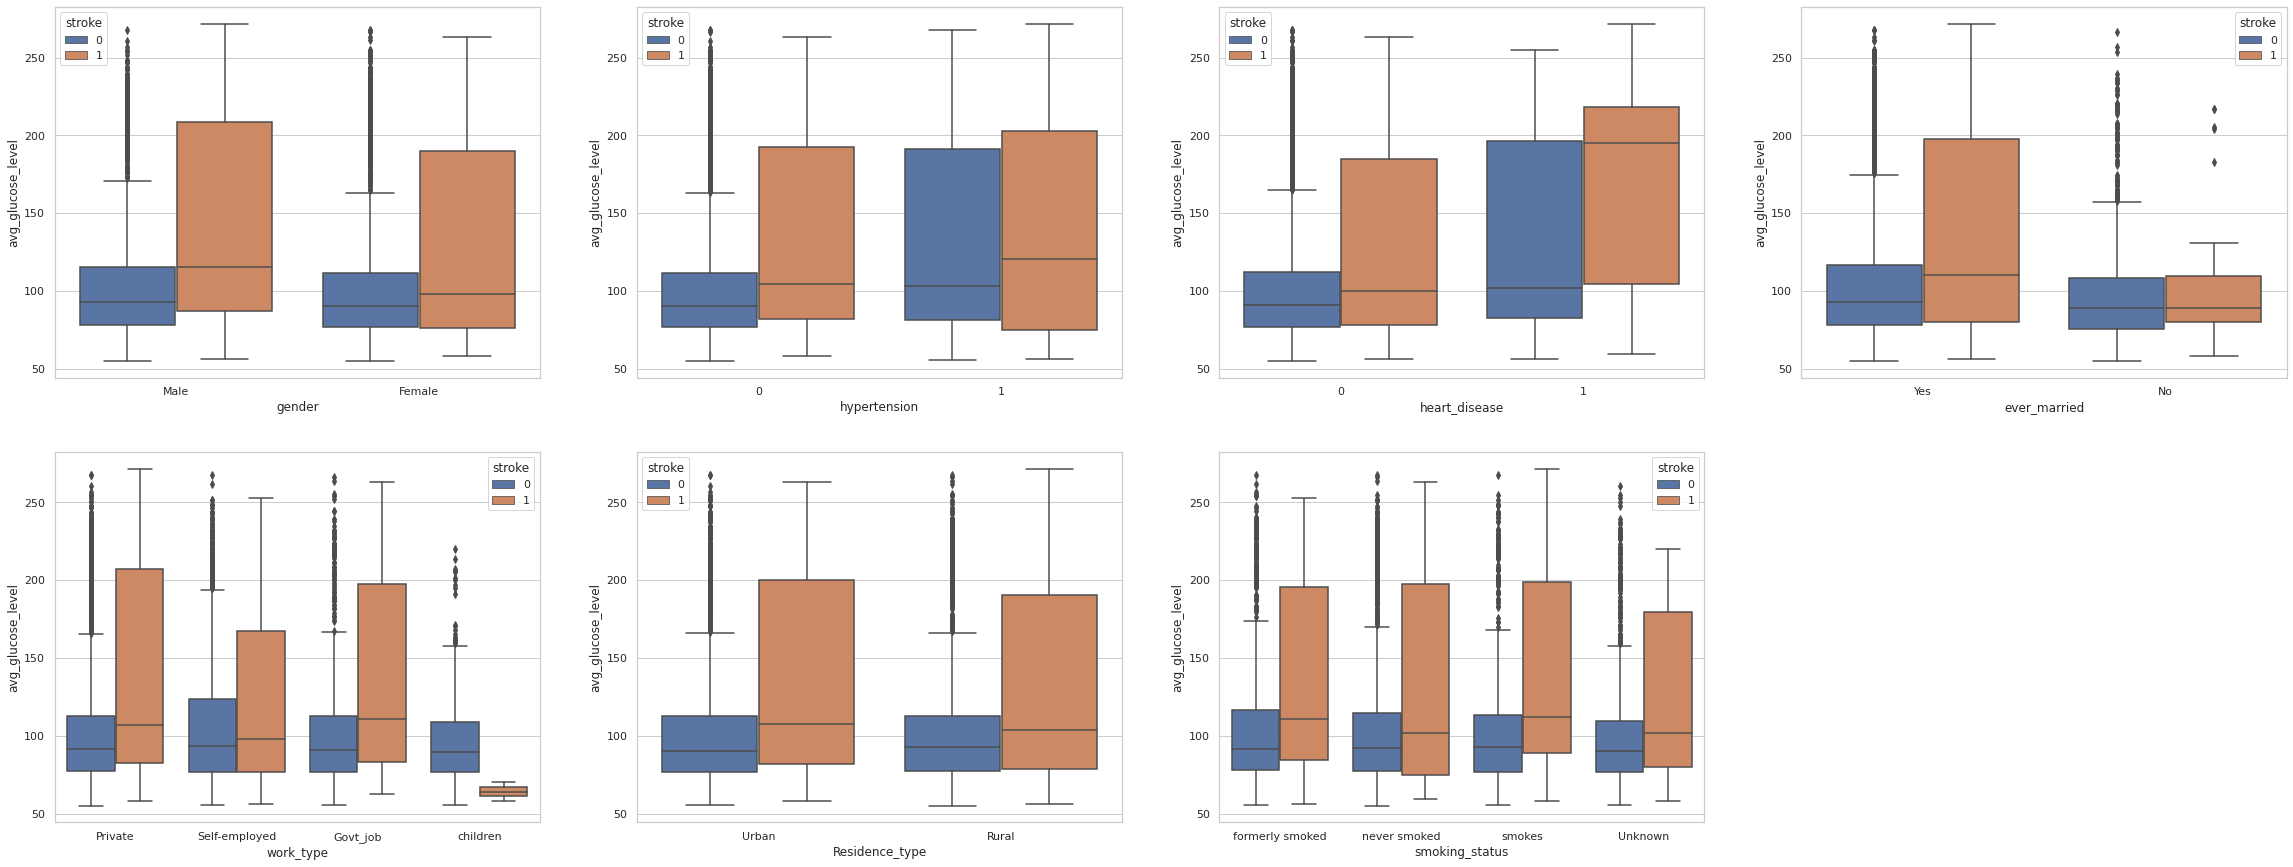

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,15))
fig.delaxes(axes[1,3])

for n, var in enumerate(categorical_vars[:len(categorical_vars)-1]):
    sns.boxplot(data = stroke_df, x=var, y='avg_glucose_level', hue=categorical_vars[-1], ax=axes[n//4][n%4])

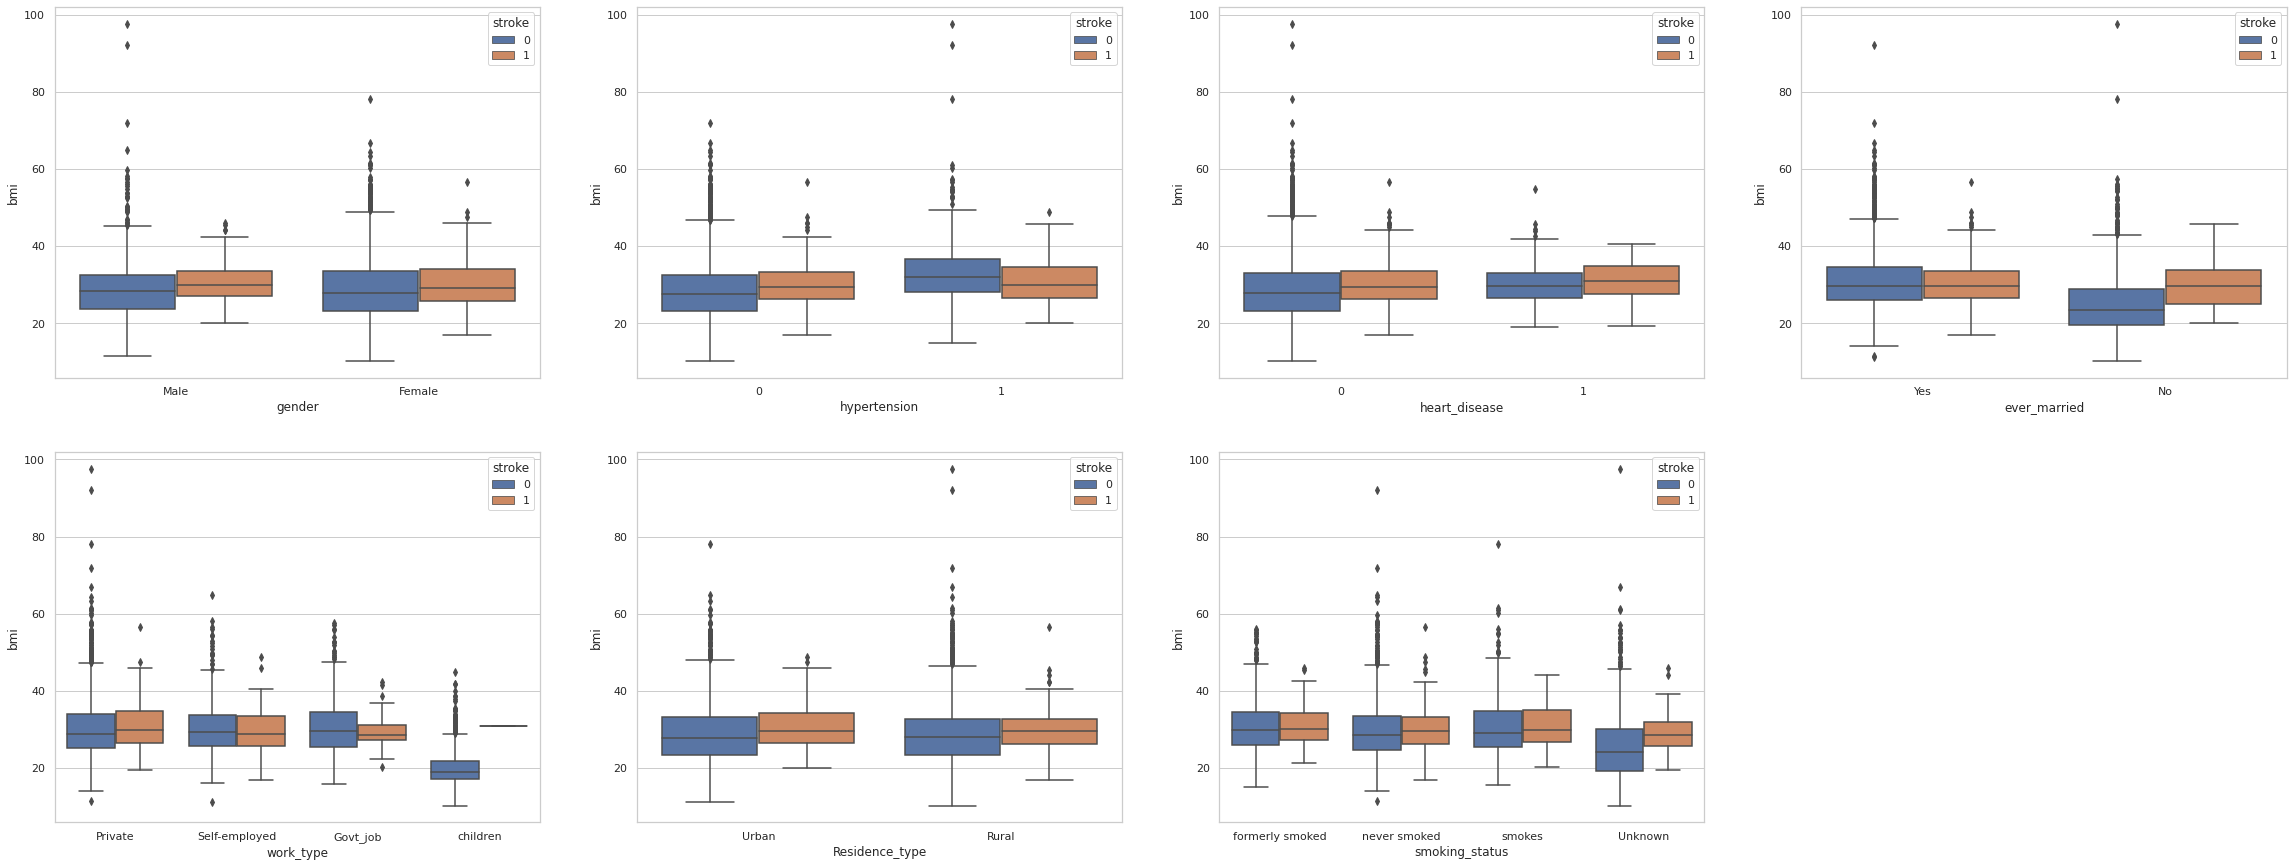

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,15))
fig.delaxes(axes[1,3])

for n, var in enumerate(categorical_vars[:len(categorical_vars)-1]):
    sns.boxplot(data = stroke_df, x=var, y='bmi', hue=categorical_vars[-1], ax=axes[n//4][n%4])

### Tratamiento de los datos faltantes

La variable BMI tiene entorno a 201 datos faltantes, que representan aprox el 4%. En lugar de eliminarlos, que reduciría la muestra de stroke=1 en como 16% y 3% de stroke=0, lo sustituiremos por el valor de la mediana de cada grupo de la variable objetivo o un valor que siga la misma distribución.

In [ ]:
stroke_df[stroke_df.isnull().any(1)].stroke.value_counts()